In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow import keras
from tensorflow.keras import layers
import time
import os
!pip install scikit-tda
import sys

# if not sys.warnoptions:
import warnings
warnings.simplefilter("ignore")

In [2]:
print (tf.__version__)

2.2.0-rc3


In [0]:
def Build_Generator_Model():
    '''
    Generator model:
    Input: random seed
    Upsamples to produce an image 
    Output: 28x28x1 image
    '''
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model 

(1, 28, 28, 1)


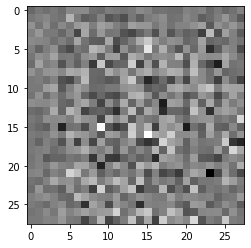

In [4]:
Generator = Build_Generator_Model()
noise = tf.random.normal([1, 100])
generated_image_test = Generator(noise, training=False)
print(generated_image_test.shape)
plt.imshow(generated_image_test[0,:,:,0], cmap='gray')

In [0]:
def Build_Discriminator_Model_Functional():
  '''
  CNN with persistence encoding concatenated 
  '''

  img_input = keras.Input(shape=[28,28,1], name='image')
  vector = keras.Input(shape=[2], name='persistence_vector')
  x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(img_input)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Flatten()(x)
  y = layers.concatenate([x,vector])
  out = layers.Dense(1)(y)
  model = keras.Model(inputs = [img_input, vector], outputs=out)
  return model

In [6]:
generated_image_test.shape

TensorShape([1, 28, 28, 1])

In [7]:
Discriminator = Build_Discriminator_Model_Functional()
Discriminator.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   1664        image[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 14, 14, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 14, 64)   0           leaky_re_lu_3[0][0]              
______________________________________________________________________________________________

In [8]:
times = tf.constant([10,1,1,1], tf.int32) 
print(tf.tile(generated_image_test, times).shape)
Decision_Test = Discriminator([generated_image_test, tf.zeros([1,2])])
#{'persistence_vector': tf.zeros([10,28], dtype=tf.float32),'image': tf.tile(generated_image_test, times)})

(10, 28, 28, 1)


In [9]:
print(Decision_Test)

tf.Tensor([[-0.00139694]], shape=(1, 1), dtype=float32)


In [0]:
Generator_Optimizer = Adam(1e-4)
Discriminator_Optimizer = Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(Generator_Optimizer=Generator_Optimizer, Discriminator_Optimizer=Discriminator_Optimizer, Generator=Generator, Discriminator=Discriminator)

In [12]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def Generator_Loss(fake_output):
    '''
    Define loss function for Generator Model 
    Discriminator output for each image is compared to an array of 1's 
    '''
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def Discriminator_Loss(real_output, fake_output):
    '''
    Defines loss function for Discriminator Model
    1 is assigned to Real Images
    0 is assigned to Fake Images
    Output: Sum Total Loss
    '''
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


from ripser import Rips
rips = Rips()

EPOCHS = 75
NOISE_DIM = 100
Num_Images_to_Generate = 10
seed = tf.random.normal([Num_Images_to_Generate, NOISE_DIM])

@tf.function
def evaluate_generator():
    noise = tf.random.normal([Batch_Size, NOISE_DIM])
    # with tf.GradientTape(watch_accessed_variables=False) as gt:
    G_Images = Generator(noise, training=False)
    return G_Images, noise

def create_persistence(images):
  images = tf.squeeze(images).numpy()
  batch_vectors=[]
  for i in range(images.shape[0]):
      img = images[i,:,:]
      diagrams = rips.fit_transform(img, metric='manhattan')
      app = [sum(x) for x in zip(*diagrams[1])]
      if len(app)<2:
        app = [0. , 0.]
      batch_vectors.append(app)
  batch_vector = tf.constant(batch_vectors)
  return batch_vector


def evaluate_discriminator(images,real_persistence, fake_persistence, noise):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        Generated_Images = Generator(noise, training=True)
        real_output = Discriminator([images, real_persistence], training=True)
        fake_output = Discriminator([Generated_Images, fake_persistence], training=True)
        Gen_Loss = Generator_Loss(fake_output)
        Disc_Loss = Discriminator_Loss(real_output, fake_output)

    Generator_Grads = gen_tape.gradient(Gen_Loss, Generator.trainable_variables)
    Discriminator_Grads = disc_tape.gradient(Disc_Loss, Discriminator.trainable_variables)
    Generator_Optimizer.apply_gradients(zip(Generator_Grads, Generator.trainable_variables))
    Discriminator_Optimizer.apply_gradients(zip(Discriminator_Grads, Discriminator.trainable_variables))


def all_together(images):
  Generated_Images, noise = evaluate_generator()
  real_persistence = create_persistence(images)
  fake_persistence = create_persistence(Generated_Images)
  evaluate_discriminator(images, real_persistence, fake_persistence, noise)

@tf.function
def Train_Step(images, zeros):
    noise = tf.random.normal([Batch_Size, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        Generated_Images = Generator(noise, training=True)
        real_output = Discriminator([images, zeros], training=True)
        fake_output = Discriminator([Generated_Images,zeros], training=True)
        Gen_Loss = Generator_Loss(fake_output)
        Disc_Loss = Discriminator_Loss(real_output, fake_output)

    Generator_Grads = gen_tape.gradient(Gen_Loss, Generator.trainable_variables)
    Discriminator_Grads = disc_tape.gradient(Disc_Loss, Discriminator.trainable_variables)
    Generator_Optimizer.apply_gradients(zip(Generator_Grads, Generator.trainable_variables))
    Discriminator_Optimizer.apply_gradients(zip(Discriminator_Grads, Discriminator.trainable_variables))


def Generate_and_Save_Images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, : , 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


def Train(Dataset, epochs):
    '''
    Train the DCGAN on a Dataset for a given number of epochs
    ''' 
    for epoch in range(epochs):
        start = time.time()

        for k, image_batch in enumerate(Dataset):
            all_together(image_batch)
            if k %70 ==0:
              print('batch {} done'.format(k))
        Generate_and_Save_Images(Generator, epoch + 1, seed)
        if(epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)
        print(f'Time for Epoch: {epoch + 1} is {time.time() - start}')
    Generate_and_Save_Images(Generator, epochs, seed)





Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [0]:
#Load data - prepare training data and normalize images to -1, 1
(train_images, train_labels), (temp_images, temp_labels) = mnist.load_data()
Train_images = np.append(train_images, temp_images, axis=0)
Train_labels = np.append(train_labels, temp_labels, axis=0)
Train_images = Train_images.reshape(Train_images.shape[0], 28, 28, 1).astype('float32')
Train_images = (Train_images - 127.5) / 127.5
Buffer_Size = 70000
Batch_Size = 250
Train_Data_Set = tf.data.Dataset.from_tensor_slices(Train_images).shuffle(Buffer_Size).batch(Batch_Size)


batch 0 done
batch 70 done
batch 140 done
batch 210 done


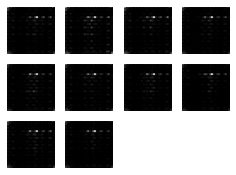

Time for Epoch: 1 is 1648.4166207313538
batch 0 done
batch 70 done
batch 140 done
batch 210 done


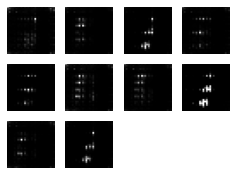

Time for Epoch: 2 is 1719.057209968567
batch 0 done
batch 70 done
batch 140 done
batch 210 done


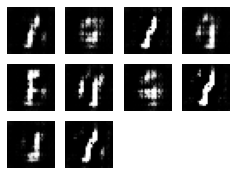

Time for Epoch: 3 is 1716.26429438591
batch 0 done
batch 70 done
batch 140 done
batch 210 done


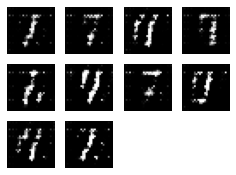

Time for Epoch: 4 is 1729.0613491535187
batch 0 done
batch 70 done
batch 140 done
batch 210 done


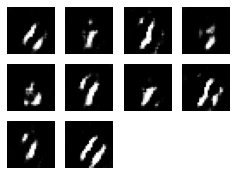

Time for Epoch: 5 is 1731.2128760814667
batch 0 done
batch 70 done
batch 140 done
batch 210 done


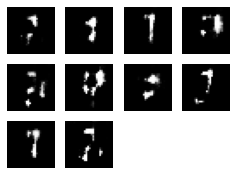

Time for Epoch: 6 is 1719.2462494373322
batch 0 done
batch 70 done
batch 140 done
batch 210 done


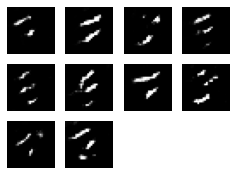

Time for Epoch: 7 is 1719.288741827011
batch 0 done
batch 70 done
batch 140 done
batch 210 done


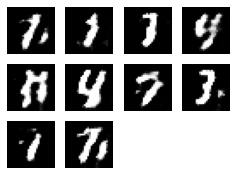

Time for Epoch: 8 is 1731.0074062347412
batch 0 done
batch 70 done
batch 140 done
batch 210 done


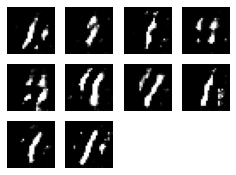

Time for Epoch: 9 is 1717.4713859558105
batch 0 done
batch 70 done
batch 140 done
batch 210 done


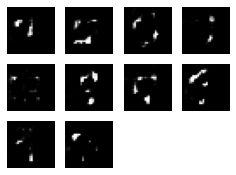

Time for Epoch: 10 is 1701.7166647911072
batch 0 done
batch 70 done
batch 140 done


In [0]:
Train(Train_Data_Set, EPOCHS)